In [184]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import csv 
import edgar
import os
import pickle
import numpy as np
import networkx as nx


Get CIK list of all investment companies

In [323]:
df_MF = pd.read_csv(r'https://goz39a.s3.eu-central-1.amazonaws.com/13F/CIK_list.csv')
df_MF['Entity Name'] = df_MF['Entity Name']
#[i.find(isin(t)) for i in df_MF.loc[df_MF['Entity Name']]]
df_MF

,Unnamed: 0,CIK Number,Entity Name,Address_1,City,State,Zip Code
0,0,2110,COLUMBIA ACORN TRUST,227 W MONROE STE 3000,CHICAGO,IL,60606
1,1,2646,Voya INTERMEDIATE BOND PORTFOLIO,ING FUNDS SERVICES,SCOTTSDALE,AZ,85258
2,2,2663,VOYA GOVERNMENT MONEY MARKET PORTFOLIO,"7337 E. DOUBLETREE RANCH ROAD, STE 100",SCOTTSDALE,AZ,85258
3,3,2664,Voya VARIABLE FUNDS,"7337 E. DOUBLETREE RANCH ROAD, STE 100",SCOTTSDALE,AZ,85258
4,4,2691,LORD ABBETT AFFILIATED FUND INC,90 HUDSON STREET,JERSEY CITY,NJ,07302
...,...,...,...,...,...,...,...
2146,2146,1810747,Simplify Exchange Traded Funds,154 W 14TH ST,NEW YORK,NY,10011
2147,2147,1811168,2nd Vote Funds,PO BOX 2916,HENDERSONVILLE,TN,37077
2148,2148,1815558,Waycross Independent Trust,"C/O ULTIMUS FUND SOLUTIONS, LLC",CINCINNATI,OH,45246
2149,2149,1815608,Modern Capital Funds Trust,1050 JOHNNIE DODDS BLVD,MT. PLEASANT,SC,29465


This will be used to link the CIK number to the company names

In [497]:
df_MF['Entity Name'].loc[df_MF['CIK Number'] == 2110].values[0]

'COLUMBIA ACORN TRUST'

download all filings from 2020-2021

In [3]:
path= r'c:/Users/michi/Desktop/filing_history'
edgar.download_index(path, 2020, skip_all_present_except_last=False)

select the URL to the edgar archive for the 13F-HR filings of 2020 until q1 of 2021 

In [188]:
def get_urls(path_download_index):
    with open(path_download_index,'r') as file:
        tsvreader = csv.reader(file, delimiter="|")
        urls= []
        file = []
        for line in tsvreader:
            if line[1:][1] == '13F-HR':
                adress=line[-1]
                url =  'https://www.sec.gov/Archives/' + adress
                holding = line[1]
                urls.append((holding.lower(), url))
    return urls

In [189]:

urls_2020_1 = get_urls(path + os.sep + '2020-QTR1.tsv')
urls_2020_2 = get_urls(path + os.sep + '2020-QTR2.tsv')
urls_2020_3 = get_urls(path + os.sep + '2020-QTR3.tsv')
urls_2020_4 = get_urls(path + os.sep + '2020-QTR4.tsv')
urls_2021 = get_urls(path + os.sep + '2021-QTR1.tsv')

Select only investment companies with 13F-HR filings in all quarters

In [282]:

urls_2020_1names, _ = zip(*urls_2020_1)
urls_2020_2names, _ = zip(*urls_2020_2)
urls_2020_3names, _ = zip(*urls_2020_3)
urls_2020_4names, _ = zip(*urls_2020_4)
urls_2021_names, _ =zip(*urls_2021)

companiesBoth = [i for i in (urls_2020_1names and urls_2020_2names and urls_2020_3names and urls_2020_4names and urls_2021_names  )]


In [283]:
len(companiesBoth)

5970

List of biggest investment companies from https://mutualfunddirectory.org/latest-directory-ranking-here/


In [191]:

URL = 'https://mutualfunddirectory.org/latest-directory-ranking-here/'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
table = soup.find('table', class_="tablepress-id-109")
for company in table.find_all('tbody'):
    rows= company.find_all('tr')
    companies =[]
    for row in rows:
        companies.append(row.find('td', class_="column-2").text)

companies = companies[:-1]
companies = [i.lower() for i in companies]


From companies with filings in each quarter, only select biggest companies 

In [296]:
urls_list=[]
period = [urls_2020_1, urls_2020_2, urls_2020_3, urls_2020_4, urls_2021]
for quarter in period:
    urls = []
    companies_quarter = [i for i in quarter if i[0] in companiesBoth]
    for company_quarter in companies_quarter:
        if len(company_quarter[0].split())>1:
            if company_quarter[0].split()[0] in companies or company_quarter[0].split()[1] in companies:
                urls.append(company_quarter[1])
        else:
             if company_quarter[0].split()[0] in companies:
                urls.append(company_quarter[1])
    urls_list.append(urls)

In [482]:
[print('number of filings: %s'%len(urls_list[i])) for i in range(len(urls_list))]

number of filings: 21
number of filings: 20
number of filings: 21
number of filings: 22
number of filings: 23


[None, None, None, None, None]

some companies have more than 1 filing

Form filing detail page on Edgar scrape the html table

In [ ]:
def parser(urls):
    '''Returns dataframe of all the securities of all filings by concatenating the filing tables found at Edgar Archives'''
    df = []
    for url in urls:
        my_header = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) ' 
                              'AppleWebKit/537.11 (KHTML, like Gecko) '
                              'Chrome/23.0.1271.64 Safari/537.11',
                'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
                'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
                'Accept-Encoding': 'none',
                'Accept-Language': 'en-US,en;q=0.8',
                'Connection': 'keep-alive'}
        #url = 'https://www.sec.gov/Archives/edgar/data/1000742/0001567619-20-003961-index.html'
        page = requests.get(url,  headers=my_header)    
        data = page.text
        soup = BeautifulSoup(data, "lxml")
        identifier = []
        urls = []

        result= soup.find_all('div', attrs={'class':'formGrouping'})[0]
        date = result.find('div',attrs={'class':'info'}).text
        index = soup.find('div',{'id':'secNum'}).text.replace('SEC Accession No. ','').replace('\n','')


        for link in soup.find_all('a'):
            try:
                if 'xml' in link.get('href'):
                    url_to_save = link.get('href')
                    identifier.append(url_to_save)
            except:
                pass

        for item in identifier:

            urls.append('https://www.sec.gov'+item)
        for url in urls:
            try:
                DF_13F = pd.read_html(url)
                DF_13F = DF_13F[-1]
                DF_13F = DF_13F.iloc[2:]
                new_header = DF_13F.iloc[0]
                DF_13F.columns = new_header
                DF_13F = DF_13F.iloc[1:]
                DF_13F['date_reported'] = date
                cik_company = url.split('data/')[1].split('/')[0]
                DF_13F['CIK'] = cik_company
                DF_13F['index'] = index
                # Get entity name from CIK code from list of all funds
                #DF_13F['Entity Name'] = df_MF['Entity Name'].loc[df_MF['CIK Number'] == cik_company].values
                DF_13F = DF_13F[['filing index','date_reported','NAME OF ISSUER','TITLE OF CLASS','CUSIP','(x$1000)','PRN AMT','PRN','CIK']]
                df.append(DF_13F)
                print('Filing found for cik %s at %s' %(cik_company,url))

            except:
                print('Could not parse cik %s at: %s'%(cik_company,url))
    return pd.concat(df)






In [ ]:
df_All = parser(urls_list[0])

In [481]:
df_All

NameError: name 'df_All' is not defined

Repeat parsing in tables for each quarter

In [350]:
df_All = {quarter_ +str(i) : parser(urls_list[i]) for i in range(4) } 


No information found for cik 1027796 at: https://www.sec.gov/Archives/edgar/data/1027796/000156761920002400/xslForm13F_X01/primary_doc.xml
No information found for cik 1027796 at: https://www.sec.gov/Archives/edgar/data/1027796/000156761920002400/primary_doc.xml
No information found for cik 1027796 at: https://www.sec.gov/Archives/edgar/data/1027796/000156761920002400/xslForm13F_X01/form13fInfoTable.xml
No information found for cik 1027796 at: https://www.sec.gov/Archives/edgar/data/1027796/000156761920002400/form13fInfoTable.xml
No information found for cik 102909 at: https://www.sec.gov/Archives/edgar/data/102909/000110465920020869/xslForm13F_X01/primary_doc.xml
No information found for cik 102909 at: https://www.sec.gov/Archives/edgar/data/102909/000110465920020869/primary_doc.xml
No information found for cik 102909 at: https://www.sec.gov/Archives/edgar/data/102909/000110465920020869/xslForm13F_X01/infotable.xml
No information found for cik 102909 at: https://www.sec.gov/Archives/e

No information found for cik 801051 at: https://www.sec.gov/Archives/edgar/data/801051/000108514620000316/form13fInfoTable.xml
No information found for cik 861177 at: https://www.sec.gov/Archives/edgar/data/861177/000086117720000005/xslForm13F_X01/primary_doc.xml
No information found for cik 861177 at: https://www.sec.gov/Archives/edgar/data/861177/000086117720000005/primary_doc.xml
No information found for cik 861177 at: https://www.sec.gov/Archives/edgar/data/861177/000086117720000005/xslForm13F_X01/Information_Table.xml
No information found for cik 861177 at: https://www.sec.gov/Archives/edgar/data/861177/000086117720000005/Information_Table.xml
No information found for cik 870481 at: https://www.sec.gov/Archives/edgar/data/870481/000156761920003538/xslForm13F_X01/primary_doc.xml
No information found for cik 870481 at: https://www.sec.gov/Archives/edgar/data/870481/000156761920003538/primary_doc.xml
No information found for cik 870481 at: https://www.sec.gov/Archives/edgar/data/8704

ValueError: No objects to concatenate

In [195]:
# save dataframe object as pickle to use in other notebooks
with open("C:/Users/michi/Desktop/MDA/df_All","wb") as f:
    pickle.dump(df_All, f)
f.close()




In [466]:
df_All=pickle.load(open('df_All',"rb"))

In [237]:
df

2,index,NAME OF ISSUER,TITLE OF CLASS,CUSIP,(x$1000),PRN AMT,PRN,cik_company,date_reported
3,0001567619-20-002400,ABBVIE INC,COM,00287Y109,281,3179,SH,1027796,2020-02-07
4,0001567619-20-002400,ACTUANT CORP- A,COM,00508X203,103856,3989841,SH,1027796,2020-02-07
5,0001567619-20-002400,AECOM,COM,00766T100,113169,2623898,SH,1027796,2020-02-07
6,0001567619-20-002400,AES CORP,COM,00130H105,909,45692,SH,1027796,2020-02-07
7,0001567619-20-002400,ALLSTATE CORP,COM,020002101,31883,283530,SH,1027796,2020-02-07
...,...,...,...,...,...,...,...,...,...
190,0000949509-20-000002,WESTERN DIGITAL CORP,CONVERTIBLE BOND,958102AP0,8875,9016000,PRN,949509,2020-02-14
191,0000949509-20-000002,WHITING PETROLEUM CORP,CONVERTIBLE BOND,966387AL6,5954,6069000,PRN,949509,2020-02-14
192,0000949509-20-000002,YETI HOLDINGS INC,COMMON STOCK,98585X104,14533,417866,SH,949509,2020-02-14
193,0000949509-20-000002,YPF SA,COMMON STOCK,984245100,15709,1356600,SH,949509,2020-02-14


In [468]:
# select part of dataframe just to test codes quickly
df=df.loc[df['(x$1000)'].astype(float)>np.quantile(df['(x$1000)'].astype(float),0.9)]

Adjacency matrix of positions for holdings

In [447]:
dummies = pd.get_dummies(df['CUSIP'])
df_=pd.concat([df[['cik_company']],dummies],axis=1)
u = df_.groupby(['cik_company']).sum()
v=np.dot(u,u.T)
# only lower triangle of matrix and diagonal=0
v=np.tril(v,-1)

In [448]:
v

array([[  0,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0],
       [  2,   1,   3,   0,   0,   0],
       [ 66, 138,   0,  51,   0,   0],
       [  2,   3,   0,   4,  67,   0]], dtype=uint8)

In [227]:
with open("C:/Users/michi/Desktop/MDA/v","wb") as f:
    pickle.dump(v, f)
f.close()

v=pickle.load(open('v',"rb"))

Matrix with edge weights from the value of the securities NOT WORKING

In [471]:
dummies = pd.get_dummies(df['CUSIP']).astype(float)
weights=dummies.T*np.asarray(df['(x$1000)']).astype(float)
weights = weights.groupby(weights.index).sum()
v=np.dot(weights,weights.T)
v=np.tril(v,-1)

In [478]:
weights.groupby(weights.index).sum()

,125,210,363,995,1784,2726,2825,5,7,10,...,14235,14236,14237,438,559,615,2886,4597,6535,7797
001055102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001084102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00123Q104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00130H105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00163UAD8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25688000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y2573F102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZQ4106303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZQ4917931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZQ8206489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13957401.0,20190804.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [432]:
weights

,125,210,363,995,1784,2726,2825,5,7,10,...,14235,14236,14237,438,559,615,2886,4597,6535,7797
001055102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001084102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00123Q104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00130H105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00163UAD8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25688000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y2573F102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZQ4106303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZQ4917931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZQ8206489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13957401.0,20190804.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Graph

{0: '1027796', 1: '102909', 2: '1109448', 3: '1132716', 4: '1291274', 5: '1454937', 6: '1502149', 7: '1529735', 8: '1535631', 9: '1599469', 10: '1599576', 11: '1610520', 12: '801051', 13: '861177', 14: '870481', 15: '9015', 16: '914208', 17: '949509'}


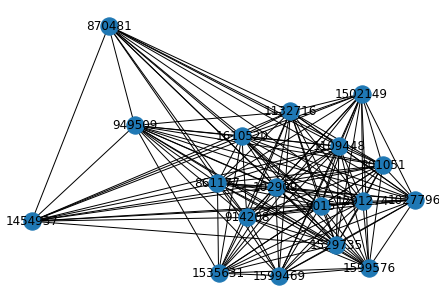

In [242]:
np.random.seed(1)
G = nx.from_numpy_matrix(v)
labels={i: u.index[i] for i in G.nodes}
    
print(labels)
G=nx.relabel_nodes(G, labels)
nx.draw_spring(G,with_labels=True)
